In [1]:
import pandas as pd
import numpy as np
import requests
import time
from datetime import datetime
from unidecode import unidecode  # Remove acentos

In [2]:
# ========================== Funções Auxiliares =================================================================================
def fazer_requisicao(url):
    """Faz a requisição à API e retorna os dados em JSON"""
    try:
        resposta = requests.get(url)
        resposta.raise_for_status()  # Levanta um erro para status 4xx e 5xx
        return resposta.json().get('dados', [])
    except requests.exceptions.RequestException as e:
        print(f"Erro ao acessar {url}: {e}")
        return []

In [3]:
# ========================== Funções Auxiliares =================================================================================
def obter_deputadas():
    """Obtém a lista de deputadas na Câmara"""
    start_time = time.time()  # Início da contagem do tempo
    url = 'https://dadosabertos.camara.leg.br/api/v2/deputados?dataInicio=2020-01-01&dataFim=2024-12-31&ordem=ASC&ordenarPor=nome'
    dados = fazer_requisicao(url)
    end_time = time.time()  # Fim da contagem do tempo
    print(f"Tempo total de execução: {end_time - start_time:.2f} segundos")
    return pd.DataFrame(dados) if dados else pd.DataFrame()

In [4]:
# ========================== Extração de dados =================================================================================
print("Baixando dados das deputadas...")
df_deputadas = obter_deputadas()

Baixando dados das deputadas...
Tempo total de execução: 6.96 segundos


In [5]:
# ========================== Funções Auxiliares =================================================================================
def obter_detalhes_deputadas(df_deputadas):
    """Obtém detalhes individuais das deputadas e retorna um DataFrame"""
    start_time = time.time()
    detalhes = []

    for id_dep in df_deputadas['id']:
        url = f"https://dadosabertos.camara.leg.br/api/v2/deputados/{id_dep}"
        data = fazer_requisicao(url)  # Sua função para obter os dados da API

        if not data:
            print(f"[ERRO] Nenhum dado retornado para id {id_dep}")
            continue

        # Converter os dados principais da deputada para DataFrame
        df_dados_deputada = pd.json_normalize(data)

        detalhes.append(df_dados_deputada)

    # Consolidar todos os detalhes em um único DataFrame
    df_resultado = pd.concat(detalhes, ignore_index=True) if detalhes else pd.DataFrame()

    elapsed_time = time.time() - start_time
    print(f"Tempo total de execução: {elapsed_time:.2f} segundos")

    return df_resultado

In [6]:
# ========================== Extração de dados =================================================================================
if not df_deputadas.empty:
    print("Baixando detalhes das deputadas...")
    df_deputadas_detalhes = obter_detalhes_deputadas(df_deputadas)
else:
    df_deputadas_detalhes = pd.DataFrame()

Baixando detalhes das deputadas...
Tempo total de execução: 193.06 segundos


In [7]:
# Junção das tabelas deputadas
df_deputadas_completo = df_deputadas.merge(df_deputadas_detalhes, on="id", how="left")

In [8]:
def obter_partidos(df_deputadas_completo):
    """Obtém detalhes dos partidos a partir da sigla e retorna um DataFrame"""
    start_time = time.time()  # Início da contagem do tempo
    url_base = "https://dadosabertos.camara.leg.br/api/v2/partidos?sigla={}&ordem=ASC&ordenarPor=sigla"
    siglas = df_deputadas_completo["siglaPartido"].dropna().unique()  # Pega siglas únicas, ignorando NaN
    dados_partidos = []

    for sigla in siglas:
        sigla_corrigida = unidecode(sigla).upper()  # Remove acentos e coloca em maiúsculas
        url = url_base.format(sigla_corrigida)  
        response = requests.get(url)
        
        if response.status_code == 200:
            data = response.json()
            if "dados" in data and len(data["dados"]) > 0:
                df_partido = pd.json_normalize(data["dados"])
                dados_partidos.append(df_partido)

    # Junta todos os dados coletados em um único DataFrame
    df_partidos = pd.concat(dados_partidos, ignore_index=True) if dados_partidos else pd.DataFrame()

    end_time = time.time()  # Fim da contagem do tempo
    print(f"Tempo total de execução: {end_time - start_time:.2f} segundos")

    return df_partidos

In [9]:
print("Baixando dados dos partidos...")
df_partidos = obter_partidos(df_deputadas_completo)

Baixando dados dos partidos...
Tempo total de execução: 38.49 segundos


In [10]:
def obter_detalhes_partidos(df_partidos):
    """
    Obtém os detalhes de cada partido utilizando o ID da lista de partidos.

    Parâmetros:
        df_partidos (pd.DataFrame): DataFrame contendo a lista de partidos, incluindo a coluna 'id'.

    Retorna:
        pd.DataFrame: DataFrame com os detalhes dos partidos, incluindo campos expandidos do 'status'.
    """
    start_time = time.time()  # Início da contagem do tempo
    detalhes_partidos = []  # Lista para armazenar os detalhes

    for partido_id in df_partidos["id"]:
        url = f"https://dadosabertos.camara.leg.br/api/v2/partidos/{partido_id}"
        dados = fazer_requisicao(url)

        if dados:
            # Converte os dados principais do partido para um DataFrame
            df_partido = pd.json_normalize(dados)

            # Expande os campos dentro de "status", se existir
            if "status" in dados:
                df_status = pd.json_normalize(dados["status"])
                df_detalhado = pd.concat([df_partido, df_status], axis=1)  # Junta os DataFrames
            else:
                df_detalhado = df_partido  # Caso não haja status, mantém apenas os dados básicos

            detalhes_partidos.append(df_detalhado)

    end_time = time.time()  # Fim da contagem do tempo
    print(f"Tempo total de execução: {end_time - start_time:.2f} segundos")

    # Concatena todos os DataFrames na lista em um único DataFrame
    return pd.concat(detalhes_partidos, ignore_index=True) if detalhes_partidos else pd.DataFrame()

print("Baixando detalhes dos partidos...")
df_detalhes_partidos = obter_detalhes_partidos(df_partidos)

Baixando detalhes dos partidos...
Tempo total de execução: 5.05 segundos


In [11]:
# Junção das tabelas partidos
df_partidos_completo = df_partidos.merge(df_detalhes_partidos, on="id", how="left")

In [12]:
def determinar_geracao(ano_nascimento):
    if ano_nascimento >= 1997:
        return "Geração Z (1997-2010)"
    elif 1981 <= ano_nascimento <= 1996:
        return "Millennials - Geração Y (1981-1996)"
    elif 1965 <= ano_nascimento <= 1980:
        return "Geração X (1965-1980)"
    elif 1946 <= ano_nascimento <= 1964:
        return "Baby Boomers (1946-1964)"
    else:
        return "Geração Silenciosa (até 1945)"

In [13]:
# ========================== Consolidação e Limpeza ==========================

In [14]:
df_deputadas_completo.isnull().sum()

id                                   0
uri_x                                0
nome                                 0
siglaPartido                         0
uriPartido                           0
siglaUf                              0
idLegislatura                        0
urlFoto                              0
email                             1595
uri_y                                0
nomeCivil                            0
cpf                                  0
sexo                                 0
urlWebsite                        2262
redeSocial                           0
dataNascimento                       0
dataFalecimento                   2274
ufNascimento                         1
municipioNascimento                  0
escolaridade                        33
ultimoStatus.id                      0
ultimoStatus.uri                     0
ultimoStatus.nome                    0
ultimoStatus.siglaPartido            0
ultimoStatus.uriPartido           2278
ultimoStatus.siglaUf     

In [15]:
df_deputadas_completo.loc[(df_deputadas_completo['ufNascimento'].isna()), 'ufNascimento'] = df_deputadas_completo['siglaUf']

In [16]:
df_deputadas_completo.loc[(df_deputadas_completo['escolaridade'].isna()), 'escolaridade'] = "Não informado"

In [17]:
df_deputadas_completo.groupby('idLegislatura')['idLegislatura'].nunique(dropna=False)

idLegislatura
56    1
57    1
Name: idLegislatura, dtype: int64

In [18]:
df_deputadas_completo.groupby('siglaPartido')['siglaPartido'].count()

siglaPartido
AVANTE            21
CIDADANIA         25
DEM               64
MDB              119
NOVO              14
PATRIOTA          19
PCdoB             13
PDT               58
PHS                4
PL               369
PODE              45
PP               176
PPS                2
PR                13
PRB                5
PRD               12
PROS              26
PSB               59
PSC               55
PSD              157
PSDB              72
PSL              165
PSOL              26
PT               132
PTB               16
PV                26
REDE               1
REPUBLICANOS     165
S.PART.           20
SOLIDARIEDADE     26
UNIÃO            373
Name: siglaPartido, dtype: int64

In [19]:
df_deputadas_completo['siglaPartido'].nunique()

31

In [20]:
df_deputadas_completo["inicioLegislatura"] = np.where(
    df_deputadas_completo["idLegislatura"] == 57, "2023-02-01",
    np.where(df_deputadas_completo["idLegislatura"] == 56, "2019-02-01", np.nan)
)

df_deputadas_completo["fimLegislatura"] = np.where(
    df_deputadas_completo["idLegislatura"] == 57, "2027-01-31",
    np.where(df_deputadas_completo["idLegislatura"] == 56, "2023-01-31", np.nan)
)

In [21]:
df_deputadas_completo.duplicated(subset=['id', 'idLegislatura', 'siglaPartido']).sum()

1294

In [22]:
df_deputadas_completo = df_deputadas_completo.drop_duplicates(subset=["id", "idLegislatura", 'siglaPartido'], keep='last')

In [23]:
df_deputadas_completo.duplicated(subset=['id', 'idLegislatura', 'siglaPartido']).sum()

0

In [24]:
df_deputadas_completo['siglaPartido'].nunique()

31

In [25]:
df_deputadas_completo.groupby('sexo', dropna=False)['id'].nunique(dropna=False)

sexo
F    103
M    449
Name: id, dtype: int64

In [26]:
df_deputadas_completo['dataNascimento'] = pd.to_datetime(df_deputadas_completo['dataNascimento']).dt.strftime('%d/%m/%Y')

In [27]:
df_deputadas_completo['inicioLegislatura'] = pd.to_datetime(df_deputadas_completo['inicioLegislatura']).dt.strftime('%d/%m/%Y')

In [28]:
df_deputadas_completo['fimLegislatura'] = pd.to_datetime(df_deputadas_completo['fimLegislatura']).dt.strftime('%d/%m/%Y')

In [29]:
df_deputadas_completo['falecida'] = df_deputadas_completo['dataFalecimento'].notna()

In [30]:
df_deputadas_completo.isnull().sum()

id                                  0
uri_x                               0
nome                                0
siglaPartido                        0
uriPartido                          0
siglaUf                             0
idLegislatura                       0
urlFoto                             0
email                             644
uri_y                               0
nomeCivil                           0
cpf                                 0
sexo                                0
urlWebsite                        976
redeSocial                          0
dataNascimento                      0
dataFalecimento                   980
ufNascimento                        0
municipioNascimento                 0
escolaridade                        0
ultimoStatus.id                     0
ultimoStatus.uri                    0
ultimoStatus.nome                   0
ultimoStatus.siglaPartido           0
ultimoStatus.uriPartido           984
ultimoStatus.siglaUf                0
ultimoStatus

In [31]:
df_deputadas_completo.loc[:, 'ano_nascimento'] = pd.to_datetime(df_deputadas_completo['dataNascimento'], dayfirst=True).dt.year

In [32]:
df_deputadas_completo.loc[:, 'geração'] = df_deputadas_completo['ano_nascimento'].apply(determinar_geracao)

In [33]:
df_deputadas_completo['geração'].value_counts()

geração
Geração X (1965-1980)                  410
Baby Boomers (1946-1964)               319
Millennials - Geração Y (1981-1996)    234
Geração Silenciosa (até 1945)           16
Geração Z (1997-2010)                    5
Name: count, dtype: int64

In [34]:
df_deputadas_completo.loc[:, 'idade'] = datetime.now().year - df_deputadas_completo['ano_nascimento']

In [35]:
df_deputadas_completo.drop(columns=['uri_x', 'uriPartido', 'urlFoto', 'email', 'uri_y', 'urlWebsite', 'redeSocial', 
                                    'ultimoStatus.uriPartido', 'ultimoStatus.email', 'ultimoStatus.gabinete.nome', 
                                    'ultimoStatus.gabinete.predio', 'ultimoStatus.gabinete.sala', 'ultimoStatus.gabinete.andar',
                                    'ultimoStatus.gabinete.telefone', 'ultimoStatus.gabinete.email', 'ultimoStatus.descricaoStatus', 
                                    'dataFalecimento'], inplace=True)

In [36]:
df_deputadas_completo.head()

,id,nome,siglaPartido,siglaUf,idLegislatura,nomeCivil,cpf,sexo,dataNascimento,ufNascimento,...,ultimoStatus.data,ultimoStatus.nomeEleitoral,ultimoStatus.situacao,ultimoStatus.condicaoEleitoral,inicioLegislatura,fimLegislatura,falecida,ano_nascimento,geração,idade
0,220593,Abilio Brunini,PL,MT,57,ABILIO JACQUES BRUNINI MOUMER,99770962104,M,31/01/1984,MT,...,2025-01-01,Abilio Brunini,Vacância,Titular,01/02/2023,31/01/2027,False,1984,Millennials - Geração Y (1981-1996),41
2,204554,Abílio Santana,PL,BA,56,JOSE ABILIO SILVA DE SANTANA,36607606504,M,13/02/1965,BA,...,2023-01-31,Abílio Santana,Fim de Mandato,Titular,01/02/2019,31/01/2023,False,1965,Geração X (1965-1980),60
4,204554,Abílio Santana,PSC,BA,56,JOSE ABILIO SILVA DE SANTANA,36607606504,M,13/02/1965,BA,...,2023-01-31,Abílio Santana,Fim de Mandato,Titular,01/02/2019,31/01/2023,False,1965,Geração X (1965-1980),60
6,204521,Abou Anni,PSL,SP,56,PAULO SERGIO ABOU ANNI,08496582841,M,06/11/1966,SP,...,2023-01-31,Abou Anni,Fim de Mandato,Titular,01/02/2019,31/01/2023,False,1966,Geração X (1965-1980),59
8,204521,Abou Anni,UNIÃO,SP,56,PAULO SERGIO ABOU ANNI,08496582841,M,06/11/1966,SP,...,2023-01-31,Abou Anni,Fim de Mandato,Titular,01/02/2019,31/01/2023,False,1966,Geração X (1965-1980),59


In [37]:
# ========================== Consolidação e Limpeza ==========================

In [38]:
df_partidos_completo.isnull().sum()

id                             0
sigla_x                        0
nome_x                         0
uri_x                          0
sigla_y                        0
nome_y                         0
uri_y                          0
numeroEleitoral               30
urlLogo                        0
urlWebSite                    30
urlFacebook                   30
status.data                    1
status.idLegislatura           0
status.situacao                1
status.totalPosse              0
status.totalMembros            0
status.uriMembros              0
status.lider.uri               0
status.lider.nome              1
status.lider.siglaPartido      1
status.lider.uriPartido        0
status.lider.uf                1
status.lider.idLegislatura     0
status.lider.urlFoto           0
data                           1
idLegislatura                  0
situacao                       1
totalPosse                     0
totalMembros                   0
uriMembros                     0
lider.uri 

In [39]:
df_partidos_completo = df_partidos_completo.rename(columns={'id': 'idPartido', 'sigla_x': 'siglaPartido', 'nome_x': 'nomePartido'})

In [40]:
df_partidos_completo.drop(columns=['uri_x', 'uri_y', 'urlLogo', 'urlWebSite', 'urlFacebook', 'status.lider.uri', 
                                   'status.lider.uriPartido', 'status.lider.urlFoto', 'uriMembros', 'lider.uri', 
                                   'lider.uriPartido', 'lider.urlFoto', 'uriMembros', 'lider.uri', 'lider.uriPartido', 
                                   'lider.urlFoto', 'sigla_y', 'nome_y', 'numeroEleitoral'], inplace=True)

In [41]:
df_partidos_completo['status.data'] = pd.to_datetime(df_partidos_completo['status.data']).dt.strftime("%d/%m/%Y")

In [42]:
df_partidos_completo['data'] = pd.to_datetime(df_partidos_completo['data']).dt.strftime("%d/%m/%Y")

In [43]:
df_partidos_completo.isnull().sum()

idPartido                     0
siglaPartido                  0
nomePartido                   0
status.data                   1
status.idLegislatura          0
status.situacao               1
status.totalPosse             0
status.totalMembros           0
status.uriMembros             0
status.lider.nome             1
status.lider.siglaPartido     1
status.lider.uf               1
status.lider.idLegislatura    0
data                          1
idLegislatura                 0
situacao                      1
totalPosse                    0
totalMembros                  0
lider.nome                    1
lider.siglaPartido            1
lider.uf                      1
lider.idLegislatura           0
dtype: int64

In [44]:
df_partidos_completo.head()

,idPartido,siglaPartido,nomePartido,status.data,status.idLegislatura,status.situacao,status.totalPosse,status.totalMembros,status.uriMembros,status.lider.nome,...,status.lider.idLegislatura,data,idLegislatura,situacao,totalPosse,totalMembros,lider.nome,lider.siglaPartido,lider.uf,lider.idLegislatura
0,37906,PL,Partido Liberal,28/02/2025,57,Ativo,99,92,https://dadosabertos.camara.leg.br/api/v2/depu...,Giacobo,...,57,28/02/2025,57,Ativo,99,92,Giacobo,PL,PR,57
1,36833,PSC,Partido Social Cristão,16/02/2022,57,Extinto,0,0,https://dadosabertos.camara.leg.br/api/v2/depu...,Euclydes Pettersen,...,57,16/02/2022,57,Extinto,0,0,Euclydes Pettersen,PSC,MG,57
2,38009,UNIÃO,União Brasil,01/02/2025,57,Ativo,59,59,https://dadosabertos.camara.leg.br/api/v2/depu...,Pedro Lucas Fernandes,...,57,01/02/2025,57,Ativo,59,59,Pedro Lucas Fernandes,UNIÃO,MA,57
3,36763,PROS,Partido Republicano da Ordem Social,12/08/2022,57,Extinto,0,0,https://dadosabertos.camara.leg.br/api/v2/depu...,Weliton Prado,...,57,12/08/2022,57,Extinto,0,0,Weliton Prado,PROS,MG,57
4,36899,MDB,Movimento Democrático Brasileiro,07/10/2024,57,Ativo,42,44,https://dadosabertos.camara.leg.br/api/v2/depu...,Isnaldo Bulhões Jr.,...,57,07/10/2024,57,Ativo,42,44,Isnaldo Bulhões Jr.,MDB,AL,57


df_diff = df_partidos_completo[df_partidos_completo['siglaPartido'] != df_partidos_completo['sigla_y']]
print(df_diff)

In [45]:
print(df_deputadas_completo['siglaPartido'].isnull().sum())
print(df_partidos_completo['siglaPartido'].isnull().sum())

0
0


In [46]:
df_partidos_completo[df_partidos_completo.isnull().any(axis=1)]

,idPartido,siglaPartido,nomePartido,status.data,status.idLegislatura,status.situacao,status.totalPosse,status.totalMembros,status.uriMembros,status.lider.nome,...,status.lider.idLegislatura,data,idLegislatura,situacao,totalPosse,totalMembros,lider.nome,lider.siglaPartido,lider.uf,lider.idLegislatura
24,36852,S.PART.,Sem Partido,NaN,57,None,0,1,,None,...,57,NaN,57,None,0,1,None,None,None,57


In [47]:
df_partidos_completo.isnull().sum()[df_partidos_completo.isnull().sum() > 0]

status.data                  1
status.situacao              1
status.lider.nome            1
status.lider.siglaPartido    1
status.lider.uf              1
data                         1
situacao                     1
lider.nome                   1
lider.siglaPartido           1
lider.uf                     1
dtype: int64

In [48]:
df_partidos_completo.fillna({
    'status.data': 'Não se aplica',
    'status.situacao': 'Não se aplica',
    'status.lider.nome': 'Não se aplica',
    'status.lider.siglaPartido': df_partidos_completo['siglaPartido'],
    'status.lider.uf': 'Não se aplica',
    'data': 'Não se aplica',
    'situacao': 'Não se aplica',
    'lider.nome': 'Não se aplica',
    'lider.siglaPartido': df_partidos_completo['siglaPartido'],
    'lider.uf': 'Não se aplica' 
}, inplace=True)

In [49]:
df_partidos_completo.isnull().sum()

idPartido                     0
siglaPartido                  0
nomePartido                   0
status.data                   0
status.idLegislatura          0
status.situacao               0
status.totalPosse             0
status.totalMembros           0
status.uriMembros             0
status.lider.nome             0
status.lider.siglaPartido     0
status.lider.uf               0
status.lider.idLegislatura    0
data                          0
idLegislatura                 0
situacao                      0
totalPosse                    0
totalMembros                  0
lider.nome                    0
lider.siglaPartido            0
lider.uf                      0
lider.idLegislatura           0
dtype: int64

In [50]:
df_partidos_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   idPartido                   30 non-null     int64 
 1   siglaPartido                30 non-null     object
 2   nomePartido                 30 non-null     object
 3   status.data                 30 non-null     object
 4   status.idLegislatura        30 non-null     object
 5   status.situacao             30 non-null     object
 6   status.totalPosse           30 non-null     object
 7   status.totalMembros         30 non-null     object
 8   status.uriMembros           30 non-null     object
 9   status.lider.nome           30 non-null     object
 10  status.lider.siglaPartido   30 non-null     object
 11  status.lider.uf             30 non-null     object
 12  status.lider.idLegislatura  30 non-null     int64 
 13  data                        30 non-null     object
 

In [51]:
df_deputadas_partidos = df_deputadas_completo.merge(df_partidos_completo, on='siglaPartido', how='left')

In [52]:
df_deputadas_partidos.head()

,id,nome,siglaPartido,siglaUf,idLegislatura_x,nomeCivil,cpf,sexo,dataNascimento,ufNascimento,...,status.lider.idLegislatura,data,idLegislatura_y,situacao,totalPosse,totalMembros,lider.nome,lider.siglaPartido,lider.uf,lider.idLegislatura
0,220593,Abilio Brunini,PL,MT,57,ABILIO JACQUES BRUNINI MOUMER,99770962104,M,31/01/1984,MT,...,57.0,28/02/2025,57,Ativo,99,92,Giacobo,PL,PR,57.0
1,204554,Abílio Santana,PL,BA,56,JOSE ABILIO SILVA DE SANTANA,36607606504,M,13/02/1965,BA,...,57.0,28/02/2025,57,Ativo,99,92,Giacobo,PL,PR,57.0
2,204554,Abílio Santana,PSC,BA,56,JOSE ABILIO SILVA DE SANTANA,36607606504,M,13/02/1965,BA,...,57.0,16/02/2022,57,Extinto,0,0,Euclydes Pettersen,PSC,MG,57.0
3,204521,Abou Anni,PSL,SP,56,PAULO SERGIO ABOU ANNI,08496582841,M,06/11/1966,SP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,204521,Abou Anni,UNIÃO,SP,56,PAULO SERGIO ABOU ANNI,08496582841,M,06/11/1966,SP,...,57.0,01/02/2025,57,Ativo,59,59,Pedro Lucas Fernandes,UNIÃO,MA,57.0


In [53]:
df_deputadas_partidos.loc[(df_deputadas_partidos['ultimoStatus.data'].isna()), 'ultimoStatus.data'] = df_deputadas_partidos['status.data']

In [54]:
df_deputadas_partidos.isnull().sum()

id                                 0
nome                               0
siglaPartido                       0
siglaUf                            0
idLegislatura_x                    0
nomeCivil                          0
cpf                                0
sexo                               0
dataNascimento                     0
ufNascimento                       0
municipioNascimento                0
escolaridade                       0
ultimoStatus.id                    0
ultimoStatus.uri                   0
ultimoStatus.nome                  0
ultimoStatus.siglaPartido          0
ultimoStatus.siglaUf               0
ultimoStatus.idLegislatura         0
ultimoStatus.urlFoto               0
ultimoStatus.data                  0
ultimoStatus.nomeEleitoral         0
ultimoStatus.situacao              0
ultimoStatus.condicaoEleitoral     0
inicioLegislatura                  0
fimLegislatura                     0
falecida                           0
ano_nascimento                     0
g

df_deputadas_completo.to_csv("deputadas.csv", index=False)  # Sem o índice
df_partidos_completo.to_csv("partidos.csv", index=False)  # Sem o índice

In [55]:
dados = fazer_requisicao('https://dadosabertos.camara.leg.br/api/v2/deputados?idLegislatura=56&siglaSexo=F&ordem=ASC&ordenarPor=nome')
df_deputadas_mulheres_56 = pd.DataFrame(dados)

dados = fazer_requisicao('https://dadosabertos.camara.leg.br/api/v2/deputados?idLegislatura=57&siglaSexo=F&ordem=ASC&ordenarPor=nome')
df_deputadas_mulheres_57 = pd.DataFrame(dados)

df_deputadas_mulheres = pd.concat([df_deputadas_mulheres_56, df_deputadas_mulheres_57], verify_integrity=True, ignore_index=True)

df_deputadas_mulheres.to_csv('deputadas_mulheres.csv', index=False)

dados = fazer_requisicao('https://dadosabertos.camara.leg.br/api/v2/deputados?siglaSexo=M&ordem=ASC&ordenarPor=nome')
df_deputados_homens = pd.DataFrame(dados)
df_deputados_homens.to_csv('deputados_homens.csv', index=False)

dados = fazer_requisicao('https://dadosabertos.camara.leg.br/api/v2/deputados?idLegislatura=56&siglaSexo=M&ordem=ASC&ordenarPor=nome')
df_deputados_homens_56 = pd.DataFrame(dados)
df_deputados_homens_56.to_csv('deputados_homens_56.csv', index=False)

In [56]:
def obter_lideres(df_partidos_completo):
    """Obtém detalhes individuais dos líderes de cada partido e retorna um DataFrame"""
    start_time = time.time()
    lideres = []

    for id_partido in df_partidos_completo['idPartido']:
        url = f"https://dadosabertos.camara.leg.br/api/v2/partidos/{id_partido}/lideres"
        dados = fazer_requisicao(url)  # Função para obter os dados da API

        if not dados:
            print(f"[ERRO] Nenhum dado retornado para id {id_partido}")
            continue

        # Converter os dados principais da deputada para DataFrame
        df_dados_lideres = pd.json_normalize(dados)
        df_dados_lideres['idPartido'] = id_partido  # Adiciona o ID do partido para referência

        lideres.append(df_dados_lideres)

    elapsed_time = time.time() - start_time
    print(f"Tempo total de execução: {elapsed_time:.2f} segundos")

    # Retorna um único DataFrame com todos os líderes
    return pd.concat(lideres, ignore_index=True) if lideres else pd.DataFrame()

In [57]:
print("Baixando dados dos líderes...")
df_lideres = obter_lideres(df_partidos_completo)

Baixando dados dos líderes...
[ERRO] Nenhum dado retornado para id 36833
[ERRO] Nenhum dado retornado para id 36763
[ERRO] Nenhum dado retornado para id 36835
[ERRO] Nenhum dado retornado para id 36814
[ERRO] Nenhum dado retornado para id 36844
[ERRO] Nenhum dado retornado para id 36769
[ERRO] Nenhum dado retornado para id 37907
[ERRO] Nenhum dado retornado para id 36839
[ERRO] Nenhum dado retornado para id 36845
[ERRO] Nenhum dado retornado para id 36852
[ERRO] Nenhum dado retornado para id 36815
[ERRO] Nenhum dado retornado para id 36813
[ERRO] Nenhum dado retornado para id 36886
[ERRO] Nenhum dado retornado para id 36793
Tempo total de execução: 4.59 segundos


In [58]:
df_lideres.head()

,id,uri,idLegislatura,nome,siglaPartido,uriPartido,siglaUf,email,urlFoto,titulo,codTitulo,dataInicio,dataFim,idPartido
0,178947,https://dadosabertos.camara.leg.br/api/v2/depu...,57,Sóstenes Cavalcante,PL,https://dadosabertos.camara.leg.br/api/v2/part...,RJ,dep.sostenescavalcante@camara.leg.br,https://www.camara.leg.br/internet/deputado/ba...,Líder,1001,2025-02-01,None,37906
1,122974,https://dadosabertos.camara.leg.br/api/v2/depu...,57,Pedro Lucas Fernandes,UNIÃO,https://dadosabertos.camara.leg.br/api/v2/part...,MA,dep.pedrolucasfernandes@camara.leg.br,https://www.camara.leg.br/internet/deputado/ba...,Líder,1001,2025-02-01,None,38009
2,178975,https://dadosabertos.camara.leg.br/api/v2/depu...,57,Baleia Rossi,MDB,https://dadosabertos.camara.leg.br/api/v2/part...,SP,dep.baleiarossi@camara.leg.br,https://www.camara.leg.br/internet/deputado/ba...,Presidente,1,2023-02-01,None,36899
3,204436,https://dadosabertos.camara.leg.br/api/v2/depu...,57,Isnaldo Bulhões Jr.,MDB,https://dadosabertos.camara.leg.br/api/v2/part...,AL,dep.isnaldobulhoesjr.@camara.leg.br,https://www.camara.leg.br/internet/deputado/ba...,Líder,1001,2023-02-01,None,36899
4,204506,https://dadosabertos.camara.leg.br/api/v2/depu...,57,Marcos Pereira,REPUBLICANOS,https://dadosabertos.camara.leg.br/api/v2/part...,SP,dep.marcospereira@camara.leg.br,https://www.camara.leg.br/internet/deputado/ba...,Presidente,1,2023-02-01,None,37908


In [59]:
def obter_lideres_legislaturas():
    """Obtém os líderes das legislaturas 56 e 57 e retorna um DataFrame"""
    start_time = time.time()
    legislaturas = [56, 57]
    lideres = []

    for legislatura in legislaturas:
        url = f"https://dadosabertos.camara.leg.br/api/v2/legislaturas/{legislatura}/lideres"
        dados = fazer_requisicao(url)

        if not dados:
            print(f"[ERRO] Nenhum dado retornado para legislatura {legislatura}")
            continue

        df_dados_lideres = pd.json_normalize(dados)
        df_dados_lideres['legislatura'] = legislatura  # Adiciona a legislatura para referência

        lideres.append(df_dados_lideres)

    elapsed_time = time.time() - start_time
    print(f"Tempo total de execução: {elapsed_time:.2f} segundos")

    return pd.concat(lideres, ignore_index=True) if lideres else pd.DataFrame()

In [60]:
df_lideres_leg = obter_lideres_legislaturas()

Tempo total de execução: 0.37 segundos


In [61]:
df_lideres_leg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   titulo                     30 non-null     object
 1   dataInicio                 30 non-null     object
 2   dataFim                    21 non-null     object
 3   parlamentar.id             30 non-null     int64 
 4   parlamentar.uri            30 non-null     object
 5   parlamentar.nome           30 non-null     object
 6   parlamentar.siglaPartido   30 non-null     object
 7   parlamentar.uriPartido     30 non-null     object
 8   parlamentar.siglaUf        30 non-null     object
 9   parlamentar.idLegislatura  30 non-null     int64 
 10  parlamentar.email          22 non-null     object
 11  parlamentar.urlFoto        30 non-null     object
 12  bancada.tipo               30 non-null     object
 13  bancada.nome               30 non-null     object
 14  bancada.uri 

In [62]:
df_lideres_leg.isnull().sum()

titulo                       0
dataInicio                   0
dataFim                      9
parlamentar.id               0
parlamentar.uri              0
parlamentar.nome             0
parlamentar.siglaPartido     0
parlamentar.uriPartido       0
parlamentar.siglaUf          0
parlamentar.idLegislatura    0
parlamentar.email            8
parlamentar.urlFoto          0
bancada.tipo                 0
bancada.nome                 0
bancada.uri                  1
legislatura                  0
dtype: int64

In [63]:
df_lideres_leg.groupby('parlamentar.siglaPartido')['parlamentar.idLegislatura'].count()

parlamentar.siglaPartido
AVANTE          3
CIDADANIA       1
MDB             3
PCdoB           1
PDT             1
PODE            2
PP              2
PRD             1
PSB             2
PSC             1
PSD             2
PSDB            2
PT              3
REDE            1
REPUBLICANOS    3
UNIÃO           2
Name: parlamentar.idLegislatura, dtype: int64

In [64]:
df_partidos_completo[df_partidos_completo['status.situacao'] == 'Ativo'].count()

idPartido                     20
siglaPartido                  20
nomePartido                   20
status.data                   20
status.idLegislatura          20
status.situacao               20
status.totalPosse             20
status.totalMembros           20
status.uriMembros             20
status.lider.nome             20
status.lider.siglaPartido     20
status.lider.uf               20
status.lider.idLegislatura    20
data                          20
idLegislatura                 20
situacao                      20
totalPosse                    20
totalMembros                  20
lider.nome                    20
lider.siglaPartido            20
lider.uf                      20
lider.idLegislatura           20
dtype: int64

In [65]:
# Apenas marca os partidos ativos, mas sem filtrar
df_partidos_completo['esta_ativo'] = df_partidos_completo['status.situacao'] == 'Ativo'

df_partidos_com_lideres = pd.merge(
    df_partidos_completo,
    df_lideres_leg,
    left_on='siglaPartido',
    right_on='parlamentar.siglaPartido',
    how='left'
)
df_partidos_com_lideres

,idPartido,siglaPartido,nomePartido,status.data,status.idLegislatura,status.situacao,status.totalPosse,status.totalMembros,status.uriMembros,status.lider.nome,...,parlamentar.siglaPartido,parlamentar.uriPartido,parlamentar.siglaUf,parlamentar.idLegislatura,parlamentar.email,parlamentar.urlFoto,bancada.tipo,bancada.nome,bancada.uri,legislatura
0,37906,PL,Partido Liberal,28/02/2025,57,Ativo,99,92,https://dadosabertos.camara.leg.br/api/v2/depu...,Giacobo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36833,PSC,Partido Social Cristão,16/02/2022,57,Extinto,0,0,https://dadosabertos.camara.leg.br/api/v2/depu...,Euclydes Pettersen,...,PSC,https://dadosabertos.camara.leg.br/api/v2/part...,SP,56.0,dep.gilbertonascimento@camara.leg.br,https://www.camara.leg.br/internet/deputado/ba...,Partido Político,PSC,https://dadosabertos.camara.leg.br/api/v2/part...,56.0
2,38009,UNIÃO,União Brasil,01/02/2025,57,Ativo,59,59,https://dadosabertos.camara.leg.br/api/v2/depu...,Pedro Lucas Fernandes,...,UNIÃO,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56.0,dep.joserocha@camara.leg.br,https://www.camara.leg.br/internet/deputado/ba...,Partido Político,PR,https://dadosabertos.camara.leg.br/api/v2/part...,56.0
3,38009,UNIÃO,União Brasil,01/02/2025,57,Ativo,59,59,https://dadosabertos.camara.leg.br/api/v2/depu...,Pedro Lucas Fernandes,...,UNIÃO,https://dadosabertos.camara.leg.br/api/v2/part...,MA,56.0,dep.pedrolucasfernandes@camara.leg.br,https://www.camara.leg.br/internet/deputado/ba...,Partido Político,PTB,https://dadosabertos.camara.leg.br/api/v2/part...,56.0
4,36763,PROS,Partido Republicano da Ordem Social,12/08/2022,57,Extinto,0,0,https://dadosabertos.camara.leg.br/api/v2/depu...,Weliton Prado,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,36899,MDB,Movimento Democrático Brasileiro,07/10/2024,57,Ativo,42,44,https://dadosabertos.camara.leg.br/api/v2/depu...,Isnaldo Bulhões Jr.,...,MDB,https://dadosabertos.camara.leg.br/api/v2/part...,SP,56.0,dep.baleiarossi@camara.leg.br,https://www.camara.leg.br/internet/deputado/ba...,Partido Político,MDB,https://dadosabertos.camara.leg.br/api/v2/part...,56.0
6,36899,MDB,Movimento Democrático Brasileiro,07/10/2024,57,Ativo,42,44,https://dadosabertos.camara.leg.br/api/v2/depu...,Isnaldo Bulhões Jr.,...,MDB,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56.0,None,https://www.camara.leg.br/internet/deputado/ba...,Partido Político,PPL,https://dadosabertos.camara.leg.br/api/v2/part...,56.0
7,36899,MDB,Movimento Democrático Brasileiro,07/10/2024,57,Ativo,42,44,https://dadosabertos.camara.leg.br/api/v2/depu...,Isnaldo Bulhões Jr.,...,MDB,https://dadosabertos.camara.leg.br/api/v2/part...,SP,57.0,dep.baleiarossi@camara.leg.br,https://www.camara.leg.br/internet/deputado/ba...,Partido Político,MDB,https://dadosabertos.camara.leg.br/api/v2/part...,57.0
8,37908,REPUBLICANOS,Republicanos,04/02/2025,57,Ativo,40,45,https://dadosabertos.camara.leg.br/api/v2/depu...,Gilberto Abramo,...,REPUBLICANOS,https://dadosabertos.camara.leg.br/api/v2/part...,RR,56.0,None,https://www.camara.leg.br/internet/deputado/ba...,Partido Político,PRB,https://dadosabertos.camara.leg.br/api/v2/part...,56.0
9,37908,REPUBLICANOS,Republicanos,04/02/2025,57,Ativo,40,45,https://dadosabertos.camara.leg.br/api/v2/depu...,Gilberto Abramo,...,REPUBLICANOS,https://dadosabertos.camara.leg.br/api/v2/part...,SP,57.0,dep.marcospereira@camara.leg.br,https://www.camara.leg.br/internet/deputado/ba...,Partido Político,REPUBLICANOS,https://dadosabertos.camara.leg.br/api/v2/part...,57.0


In [66]:
# Cria uma tabela com os nomes dos líderes por partido e legislatura
tabela_lideres_nomes = df_lideres_leg.pivot_table(
    index='parlamentar.siglaPartido',
    columns='legislatura',
    values='parlamentar.nome',
    aggfunc='first'  # usa o primeiro nome encontrado (normalmente só há um)
)

# Renomeia as colunas para ficar mais claro
tabela_lideres_nomes.columns = [f'lider_{col}' for col in tabela_lideres_nomes.columns]

# Reseta o índice para deixar a sigla do partido como coluna
tabela_lideres_nomes.reset_index(inplace=True)

# Visualiza a tabela
print(tabela_lideres_nomes)


   parlamentar.siglaPartido              lider_56          lider_57
0                    AVANTE            Luis Tibé          Luis Tibé
1                 CIDADANIA        Daniel Coelho                NaN
2                       MDB         Baleia Rossi       Baleia Rossi
3                     PCdoB        Orlando Silva                NaN
4                       PDT                   NaN  André Figueiredo
5                      PODE                   NaN      Renata Abreu
6                        PP           José Nelto       André Fufuca
7                       PRD                   NaN        Fred Costa
8                       PSB        Tadeu Alencar    Felipe Carreras
9                       PSC  Gilberto Nascimento                NaN
10                      PSD       André de Paula      Antonio Brito
11                     PSDB       Carlos Sampaio       Adolfo Viana
12                       PT        Paulo Pimenta    Gleisi Hoffmann
13                     REDE     Joenia Wapichana

In [67]:
# Transforma a tabela de líderes em formato "long"
lideres_long = pd.melt(
    tabela_lideres_nomes,
    id_vars=['parlamentar.siglaPartido'],
    value_vars=['lider_56', 'lider_57'],
    var_name='legislatura',
    value_name='nome_lider'
)

# Remove nulos (sem líder)
lideres_long = lideres_long.dropna(subset=['nome_lider'])

# Agora junta com df_deputadas_completo para pegar o sexo dos líderes
df_lideres_sexo = lideres_long.merge(
    df_deputadas_completo[['nome', 'sexo']],
    left_on='nome_lider',
    right_on='nome',
    how='left'
)

# Visualiza
print(df_lideres_sexo[['parlamentar.siglaPartido', 'legislatura', 'nome_lider', 'sexo']])


   parlamentar.siglaPartido legislatura            nome_lider sexo
0                    AVANTE    lider_56            Luis Tibé   NaN
1                 CIDADANIA    lider_56        Daniel Coelho   NaN
2                       MDB    lider_56         Baleia Rossi   NaN
3                     PCdoB    lider_56        Orlando Silva   NaN
4                        PP    lider_56           José Nelto   NaN
5                       PSB    lider_56        Tadeu Alencar   NaN
6                       PSC    lider_56  Gilberto Nascimento   NaN
7                       PSD    lider_56       André de Paula   NaN
8                      PSDB    lider_56       Carlos Sampaio   NaN
9                        PT    lider_56        Paulo Pimenta   NaN
10                     REDE    lider_56     Joenia Wapichana   NaN
11             REPUBLICANOS    lider_56    Jhonatan de Jesus   NaN
12                    UNIÃO    lider_56           José Rocha   NaN
13                   AVANTE    lider_57             Luis Tibé 

In [68]:
def obter_sexo_por_id(lista_ids):
    """Consulta a API da Câmara para obter o sexo de parlamentares por ID"""
    dados = []

    for id_ in lista_ids:
        url = f"https://dadosabertos.camara.leg.br/api/v2/deputados/{id_}"
        response = requests.get(url)

        if response.status_code == 200:
            info = response.json()
            sexo = info['dados'].get('sexo', 'Não informado')
            dados.append({'id': id_, 'sexo': sexo})
        else:
            print(f"[ERRO] Não foi possível acessar dados para o ID {id_}")
            dados.append({'id': id_, 'sexo': 'Erro'})

    return pd.DataFrame(dados)


In [69]:
ids_unicos = df_lideres_leg['parlamentar.id'].dropna().unique()
df_sexo = obter_sexo_por_id(ids_unicos)

In [70]:
# Agora você junta com seu DataFrame original:
df_lideres_leg = df_lideres_leg.merge(df_sexo, left_on='parlamentar.id', right_on='id', how='left')
df_lideres_leg

,titulo,dataInicio,dataFim,parlamentar.id,parlamentar.uri,parlamentar.nome,parlamentar.siglaPartido,parlamentar.uriPartido,parlamentar.siglaUf,parlamentar.idLegislatura,parlamentar.email,parlamentar.urlFoto,bancada.tipo,bancada.nome,bancada.uri,legislatura,id,sexo
0,Líder,2019-02-01,2019-03-20,74554,https://dadosabertos.camara.leg.br/api/v2/depu...,José Rocha,UNIÃO,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,dep.joserocha@camara.leg.br,https://www.camara.leg.br/internet/deputado/ba...,Partido Político,PR,https://dadosabertos.camara.leg.br/api/v2/part...,56,74554,M
1,Líder,2019-02-01,2020-03-03,178922,https://dadosabertos.camara.leg.br/api/v2/depu...,Tadeu Alencar,PSB,https://dadosabertos.camara.leg.br/api/v2/part...,PE,56,None,https://www.camara.leg.br/internet/deputado/ba...,Partido Político,PSB,https://dadosabertos.camara.leg.br/api/v2/part...,56,178922,M
2,Líder,2019-02-01,2019-03-20,178987,https://dadosabertos.camara.leg.br/api/v2/depu...,Orlando Silva,PCdoB,https://dadosabertos.camara.leg.br/api/v2/part...,SP,56,dep.orlandosilva@camara.leg.br,https://www.camara.leg.br/internet/deputado/ba...,Partido Político,PCdoB,https://dadosabertos.camara.leg.br/api/v2/part...,56,178987,M
3,Líder,2019-02-01,2019-02-05,74270,https://dadosabertos.camara.leg.br/api/v2/depu...,Gilberto Nascimento,PSC,https://dadosabertos.camara.leg.br/api/v2/part...,SP,56,dep.gilbertonascimento@camara.leg.br,https://www.camara.leg.br/internet/deputado/ba...,Partido Político,PSC,https://dadosabertos.camara.leg.br/api/v2/part...,56,74270,M
4,Líder,2019-02-01,2020-02-01,74400,https://dadosabertos.camara.leg.br/api/v2/depu...,Paulo Pimenta,PT,https://dadosabertos.camara.leg.br/api/v2/part...,RS,56,dep.paulopimenta@camara.leg.br,https://www.camara.leg.br/internet/deputado/ba...,Partido Político,PT,https://dadosabertos.camara.leg.br/api/v2/part...,56,74400,M
5,Líder,2019-02-01,2021-01-27,122974,https://dadosabertos.camara.leg.br/api/v2/depu...,Pedro Lucas Fernandes,UNIÃO,https://dadosabertos.camara.leg.br/api/v2/part...,MA,56,dep.pedrolucasfernandes@camara.leg.br,https://www.camara.leg.br/internet/deputado/ba...,Partido Político,PTB,https://dadosabertos.camara.leg.br/api/v2/part...,56,122974,M
6,Líder,2019-02-01,2020-02-04,74471,https://dadosabertos.camara.leg.br/api/v2/depu...,André de Paula,PSD,https://dadosabertos.camara.leg.br/api/v2/part...,PE,56,None,https://www.camara.leg.br/internet/deputado/ba...,Partido Político,PSD,https://dadosabertos.camara.leg.br/api/v2/part...,56,74471,M
7,Líder,2019-02-01,2019-08-16,160531,https://dadosabertos.camara.leg.br/api/v2/depu...,Jhonatan de Jesus,REPUBLICANOS,https://dadosabertos.camara.leg.br/api/v2/part...,RR,56,None,https://www.camara.leg.br/internet/deputado/ba...,Partido Político,PRB,https://dadosabertos.camara.leg.br/api/v2/part...,56,160531,M
8,Líder,2019-02-01,2019-12-11,74262,https://dadosabertos.camara.leg.br/api/v2/depu...,Carlos Sampaio,PSDB,https://dadosabertos.camara.leg.br/api/v2/part...,SP,56,dep.carlossampaio@camara.leg.br,https://www.camara.leg.br/internet/deputado/ba...,Partido Político,PSDB,https://dadosabertos.camara.leg.br/api/v2/part...,56,74262,M
9,Líder,2019-02-01,2019-04-05,178916,https://dadosabertos.camara.leg.br/api/v2/depu...,Daniel Coelho,CIDADANIA,https://dadosabertos.camara.leg.br/api/v2/part...,PE,56,None,https://www.camara.leg.br/internet/deputado/ba...,Partido Político,PPS,https://dadosabertos.camara.leg.br/api/v2/part...,56,178916,M


In [71]:
print(df_lideres_leg[['parlamentar.siglaPartido', 'legislatura', 'parlamentar.nome', 'sexo']])

   parlamentar.siglaPartido  legislatura        parlamentar.nome sexo
0                     UNIÃO           56             José Rocha     M
1                       PSB           56          Tadeu Alencar     M
2                     PCdoB           56          Orlando Silva     M
3                       PSC           56    Gilberto Nascimento     M
4                        PT           56          Paulo Pimenta     M
5                     UNIÃO           56  Pedro Lucas Fernandes     M
6                       PSD           56         André de Paula     M
7              REPUBLICANOS           56      Jhonatan de Jesus     M
8                      PSDB           56         Carlos Sampaio     M
9                 CIDADANIA           56          Daniel Coelho     M
10                       PP           56             José Nelto     M
11                      MDB           56           Baleia Rossi     M
12                   AVANTE           56              Luis Tibé     M
13                  

In [72]:
df_lideres_leg.isnull().sum()

titulo                       0
dataInicio                   0
dataFim                      9
parlamentar.id               0
parlamentar.uri              0
parlamentar.nome             0
parlamentar.siglaPartido     0
parlamentar.uriPartido       0
parlamentar.siglaUf          0
parlamentar.idLegislatura    0
parlamentar.email            8
parlamentar.urlFoto          0
bancada.tipo                 0
bancada.nome                 0
bancada.uri                  1
legislatura                  0
id                           0
sexo                         0
dtype: int64

In [73]:
df_lideres_leg.drop(columns=['parlamentar.email', 'bancada.uri'], inplace=True)

In [74]:
filtro_nulo = df_lideres_leg["dataFim"].isnull()
df_lideres_leg.loc[filtro_nulo, "dataFim"] = df_lideres_leg.loc[filtro_nulo, "legislatura"].map({
    57: "2027-01-31",
    56: "2023-01-31"
})

In [75]:
df_lideres_leg.isnull().sum()

titulo                       0
dataInicio                   0
dataFim                      0
parlamentar.id               0
parlamentar.uri              0
parlamentar.nome             0
parlamentar.siglaPartido     0
parlamentar.uriPartido       0
parlamentar.siglaUf          0
parlamentar.idLegislatura    0
parlamentar.urlFoto          0
bancada.tipo                 0
bancada.nome                 0
legislatura                  0
id                           0
sexo                         0
dtype: int64

In [76]:
df_lideres_leg["dataInicio"] = pd.to_datetime(df_lideres_leg["dataInicio"])
df_lideres_leg["dataFim"] = pd.to_datetime(df_lideres_leg["dataFim"])

df_lideres_leg.to_csv('lideres.csv', index=False)

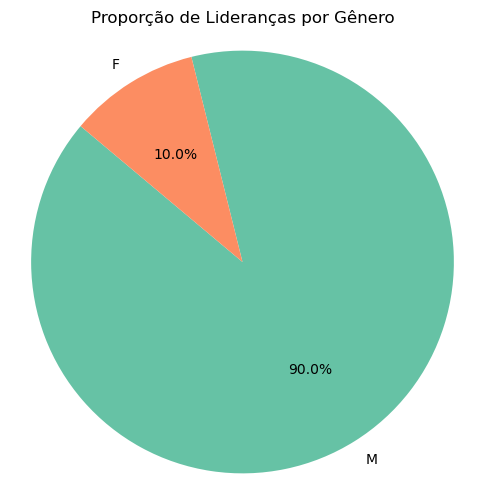

In [77]:
import matplotlib.pyplot as plt

# Contar lideranças por gênero
genero_counts = df_lideres_leg["sexo"].value_counts()

# Gráfico de pizza
plt.figure(figsize=(6, 6))
plt.pie(genero_counts, labels=genero_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62'])
plt.title('Proporção de Lideranças por Gênero')
plt.axis('equal')
plt.show()


In [78]:
df_lideres_leg.groupby('sexo', dropna=False).size()

sexo
F     3
M    27
dtype: int64

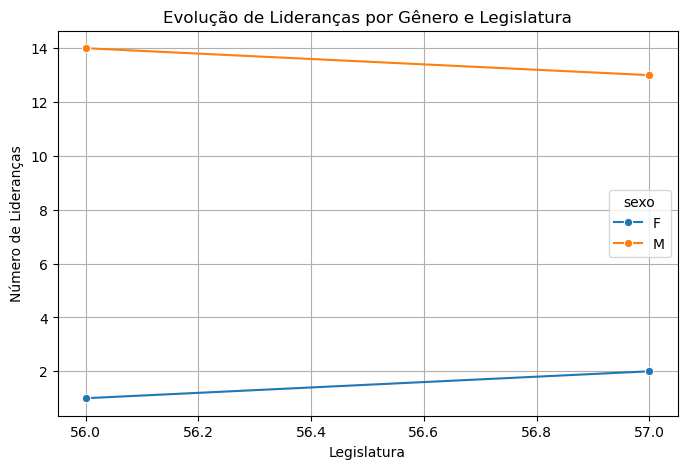

In [79]:
import seaborn as sns

# Agrupar por legislatura e sexo
evolucao = df_lideres_leg.groupby(["legislatura", "sexo"]).size().reset_index(name='contagem')

# Gráfico de linha
plt.figure(figsize=(8, 5))
sns.lineplot(data=evolucao, x="legislatura", y="contagem", hue="sexo", marker='o')
plt.title("Evolução de Lideranças por Gênero e Legislatura")
plt.xlabel("Legislatura")
plt.ylabel("Número de Lideranças")
plt.grid(True)
plt.show()

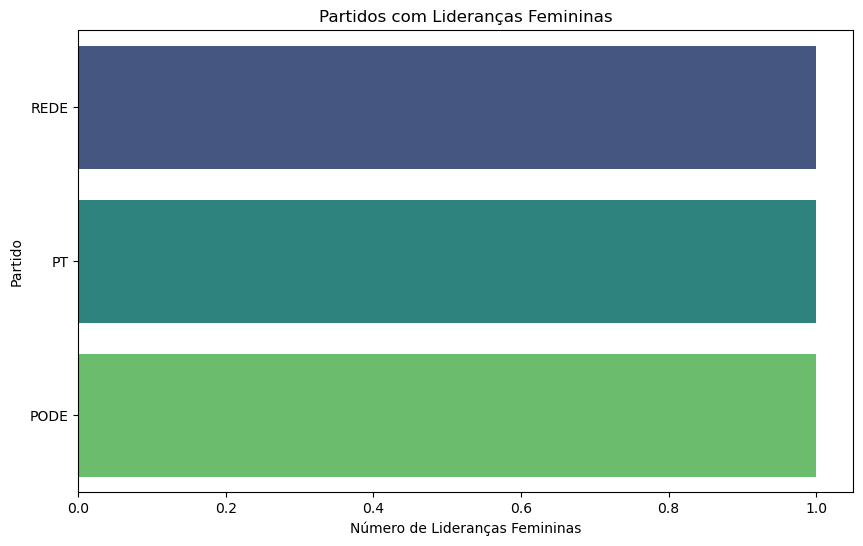

In [80]:
# Filtrar apenas lideranças femininas
liderancas_femininas = df_lideres_leg[df_lideres_leg["sexo"] == "F"]

# Contar por partido
partidos_femininos = liderancas_femininas["parlamentar.siglaPartido"].value_counts().reset_index()
partidos_femininos.columns = ["parlamentar.siglaPartido", "quantidade"]

# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=partidos_femininos, y="parlamentar.siglaPartido", x="quantidade", hue="parlamentar.siglaPartido", palette="viridis", legend=False)
plt.title("Partidos com Lideranças Femininas")
plt.xlabel("Número de Lideranças Femininas")
plt.ylabel("Partido")
plt.show()

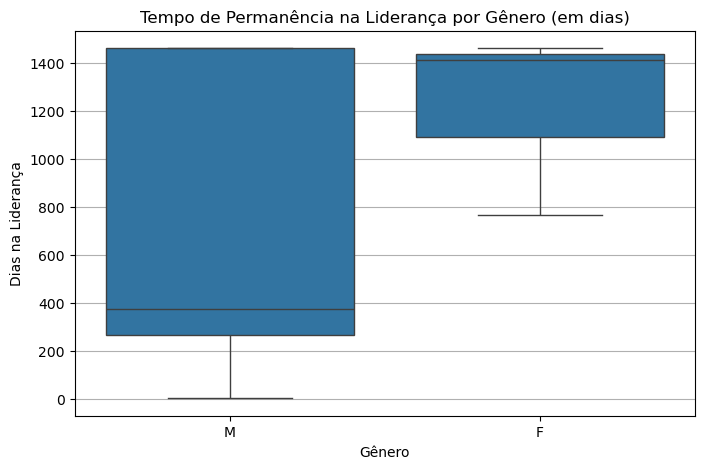

In [81]:
# Garantir que as colunas sejam datetime
df_lideres_leg["dataInicio"] = pd.to_datetime(df_lideres_leg["dataInicio"])
df_lideres_leg["dataFim"] = pd.to_datetime(df_lideres_leg["dataFim"])

# Criar uma nova coluna com duração em dias
df_lideres_leg["dias_na_lideranca"] = (df_lideres_leg["dataFim"] - df_lideres_leg["dataInicio"]).dt.days

# Boxplot por sexo
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_lideres_leg, x="sexo", y="dias_na_lideranca")
plt.title("Tempo de Permanência na Liderança por Gênero (em dias)")
plt.xlabel("Gênero")
plt.ylabel("Dias na Liderança")
plt.grid(True, axis='y')
plt.show()

In [82]:
# Cria uma tabela de id_deputado com os anos em que apareceram
tabela_legislaturas = df_deputadas_completo.groupby('id')['idLegislatura'].nunique().reset_index()

# Deputadas que aparecem em dois anos => reeleitas
tabela_legislaturas['reeleita'] = tabela_legislaturas['idLegislatura'] > 1


In [83]:
# Junta com o DataFrame original
df_deputadas_completo = df_deputadas_completo.merge(tabela_legislaturas[['id', 'reeleita']], on='id', how='left')


In [84]:
deputadas_reeleitas = df_deputadas_completo[df_deputadas_completo['reeleita']].drop_duplicates('id')
print(f"Deputadas reeleitas: {len(deputadas_reeleitas)}")


Deputadas reeleitas: 210


In [86]:
novatas_2023 = df_deputadas_completo[(df_deputadas_completo['idLegislatura'] == 57) & (~df_deputadas_completo['reeleita'])]
novatas_2023 = novatas_2023.drop_duplicates('id')
print(f"Deputadas novatas em 2023: {len(novatas_2023)}")

Deputadas novatas em 2023: 174


In [87]:
total_2019 = df_deputadas_completo[df_deputadas_completo['idLegislatura'] == 56]['id'].nunique()
reeleitas = deputadas_reeleitas['id'].nunique()
percentual_reeleicao = (reeleitas / total_2019) * 100
print(f"Percentual de reeleição entre deputadas de 2019: {percentual_reeleicao:.2f}%")


Percentual de reeleição entre deputadas de 2019: 55.56%


In [88]:
def contar_deputadas(df, legislatura=None, tipo='total'):
    """
    Conta deputadas eleitas, com opção de contagem total (mandatos) ou distinta (únicas).
    
    Parâmetros:
    - df: DataFrame com as deputadas
    - legislatura: int ou lista (ex: 56 ou [56, 57])
    - tipo: 'total' para contar mandatos, 'distinta' para contar deputadas únicas
    
    Retorna: inteiro com o número de deputadas
    """
    df_fem = df[df['sexo'] == 'F']
    
    if legislatura:
        if isinstance(legislatura, int):
            df_fem = df_fem[df_fem['idLegislatura'] == legislatura]
        elif isinstance(legislatura, list):
            df_fem = df_fem[df_fem['idLegislatura'].isin(legislatura)]

    if tipo == 'total':
        return len(df_fem)
    elif tipo == 'distinta':
        return df_fem['id'].nunique()
    else:
        raise ValueError("Tipo inválido: use 'total' ou 'distinta'")


In [91]:
print("🔍 Exemplos com df_deputadas_completo\n")

# Total de mandatos femininos em 2019 (legislatura 56)
total_2019 = contar_deputadas(df_deputadas_completo, 56, tipo='total')
print(f"Total de mandatos femininos em 2019: {total_2019}")

# Total de mandatos femininos em 2023 (legislatura 57)
total_2023 = contar_deputadas(df_deputadas_completo, 57, tipo='total')
print(f"Total de mandatos femininos em 2023: {total_2023}")

# Total de mandatos (mesmo nome conta duas vezes) entre 2019 e 2023
total_ambos = contar_deputadas(df_deputadas_completo, [56, 57], tipo='total')
print(f"Total de mandatos femininos entre 2019 e 2023: {total_ambos}")

# Total de deputadas únicas em 2019
distintas_2019 = contar_deputadas(df_deputadas_completo, 56, tipo='distinta')
print(f"Total de deputadas únicas em 2019: {distintas_2019}")

# Total de deputadas únicas em 2023
distintas_2023 = contar_deputadas(df_deputadas_completo, 57, tipo='distinta')
print(f"Total de deputadas únicas em 2023: {distintas_2023}")

# Total de deputadas únicas entre 2019 e 2023
distintas_ambos = contar_deputadas(df_deputadas_completo, [56, 57], tipo='distinta')
print(f"Total de deputadas únicas entre 2019 e 2023: {distintas_ambos}")

🔍 Exemplos com df_deputadas_completo

Total de mandatos femininos em 2019: 91
Total de mandatos femininos em 2023: 76
Total de mandatos femininos entre 2019 e 2023: 167
Total de deputadas únicas em 2019: 56
Total de deputadas únicas em 2023: 74
Total de deputadas únicas entre 2019 e 2023: 103
